In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
#from tqdm import tqdm_notebook as tqdm

/usr/lib/python3/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
from auto_elm import AUTO_ELM   # Our proposed algorithm
n_input_nodes = 4096
n_hidden_nodes = 125  # used to be 256
n_output_nodes = 4096

In [27]:
DIR = '/home/adhri/MFB_ELM_rewrite_March-14/'

x_train = np.load(DIR+'train_x_deep_feature.npy')/100.
y_train = np.load(DIR+'train_y_labels.npy')
x_test = np.load(DIR+'test_x_deep_feature.npy')/100.
y_test = np.load(DIR+'test_y_labels.npy')

In [28]:
"""shuffle dataset"""
p = np.random.permutation(len(x_train))
x_train = x_train[p]
y_train = y_train[p]
x_train.shape

(50000, 4096)

In [29]:
n_input_nodes = 4096
n_output_nodes = 4096

In [31]:
accuracy_sum = 0
time_sum = 0
for PPAP in range(10):
	tf.reset_default_graph()

	"""BP autoencoder"""
	X = tf.placeholder(tf.float32, [None, n_input_nodes])
	Y = tf.placeholder(tf.float32, [None, n_output_nodes])

	encoding_layer = tf.layers.dense(inputs=X,units=n_hidden_nodes,activation=tf.math.sin)
	Y_hat = tf.layers.dense(inputs=encoding_layer,units=n_output_nodes,activation=None)

	loss = tf.losses.mean_squared_error(labels=Y,predictions=Y_hat)

	optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

	sess = tf.Session()
	sess.run(tf.global_variables_initializer())

	t1 = time.time()
	BATCH_SIZE = 128
	for epoch in range(100):
		i = 0
		while i < len(x_train):
			try:
				batch_x = x_train[i:i+BATCH_SIZE]
				batch_y = x_train[i:i+BATCH_SIZE]
			except:
				batch_x = x_train[i:]
				batch_y = x_train[i:]
			i+=BATCH_SIZE
			sess.run(optimizer, feed_dict={X:batch_x, Y:batch_y})
	t2 = time.time()
	time_sum+=(t2-t1)

	"""classification"""
	x_train_encoded = sess.run(encoding_layer, feed_dict={X: x_train})
	x_test_encoded = sess.run(encoding_layer, feed_dict={X: x_test})

	X = tf.placeholder(tf.float32, [None, n_hidden_nodes])
	Y = tf.placeholder(tf.int64, [None])
	Y_ = tf.one_hot(indices=Y, depth=10) # one_hot labels: [N,M]

	fc1 = tf.layers.dense(inputs=X,units=512,activation=tf.nn.relu)
	fc2 = tf.layers.dense(inputs=fc1,units=512,activation=tf.nn.relu)
	out = tf.layers.dense(inputs=fc2,units=10,activation=None)

	loss = tf.losses.softmax_cross_entropy(logits=out,onehot_labels=Y_)
	accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(out,axis=1),tf.argmax(Y_,axis=1)),dtype=tf.float32))

	optimizer = tf.train.AdamOptimizer(learning_rate=0.001).minimize(loss)

	sess = tf.Session()
	sess.run(tf.global_variables_initializer())

	BATCH_SIZE = 128
	for epoch in range(100):
		i = 0
		while i < len(x_train_encoded):
			try:
				batch_x = x_train_encoded[i:i+BATCH_SIZE]
				batch_y = y_train[i:i+BATCH_SIZE]
			except:
				batch_x = x_train_encoded[i:]
				batch_y = y_train[i:]
			i+=BATCH_SIZE
			sess.run(optimizer, feed_dict={X:batch_x, Y:batch_y})

	"""evaluation"""
	avg_testing_acc = sess.run(accuracy, feed_dict={X: x_test_encoded, Y: y_test})
	print("Testing accuracy: ",avg_testing_acc)
	accuracy_sum+=avg_testing_acc

print("==========================================")
print("BP	 ===================================")
print("==========================================")
print("Average time: ", time_sum/10.0)
print("Average accuracy: ", accuracy_sum/10.0)
print("==========================================")

ValueError: Cannot feed value of shape (128, 10) for Tensor 'Placeholder_3:0', which has shape '(?,)'

In [6]:
border = 1000
x_train_init = x_train[:border]
x_train_seq = x_train[border:]

In [7]:
x_train_init.shape

(1000, 4096)

In [8]:
y_train.shape

(50000, 10)

In [9]:
import time
accuracy_sum = 0
time_sum = 0
for PPAP in range(10):
	tf.reset_default_graph()
	# ===========================================
	# Instantiate os-elm
	# ===========================================
	auto_elm = AUTO_ELM(
		# the number of input nodes.
		n_input_nodes=n_input_nodes,
		# the number of hidden nodes.
		n_hidden_nodes=n_hidden_nodes,
		# the number of output nodes.
		n_output_nodes=n_output_nodes,
		# loss function.
		# the default value is 'mean_squared_error'.
		# for the other functions, we support
		# 'mean_absolute_error', 'categorical_crossentropy', and 'binary_crossentropy'.
		c_value = 2.0**(2),
		loss='mean_squared_error',
		# activation function applied to the hidden nodes.
		# the default value is 'sigmoid'.
		# for the other functions, we support 'linear' and 'tanh'.
		# NOTE: OS-ELM can apply an activation function only to the hidden nodes.
		activation='sin',
	)
	# ===========================================
	# Training
	# ===========================================
	# the initial training phase
	t1 = time.time()
	auto_elm.init_train(x_train_init, x_train_init)
	t2 = time.time()
	time_sum+=(t2-t1)

	# the sequential training phase
	batch_size = 1014

	t1 = time.time()
	for epoch in range(100):
		for i in range(0, len(x_train_seq), batch_size):
			x_batch = x_train_seq[i:i+batch_size]
			if len(x_batch) != batch_size:
				break
			auto_elm.seq_train(x_batch, x_batch)
	t2 = time.time()
	time_sum+=(t2-t1)

In [9]:
time_sum = time_sum/10
#time_sum = 4.07573

In [11]:
x_train_encoded = auto_elm.encoding(x_train)
x_test_encoded = auto_elm.encoding(x_test)

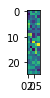

In [13]:
x_train_encoded[0].shape
img = x_train_encoded[0]
g = img.reshape(25,5)
plt.subplot(321)
plt.imshow(g)

In [ ]:
img = x_train_encoded[0]
reconstructed_img = img.view(1,-1).type(torch.FloatTensor)

_,reconstructed_img= dbn_mnist.reconstruct(reconstructed_img)

reconstructed_img = reconstructed_img.view((28,28))
print("The original number: {}".format(mnist_data.train_labels[idx]))
plt.imshow(img ,)
plt.show()
print("The reconstructed image")
plt.imshow(reconstructed_img)
plt.show()

In [ ]:
def visualize_alpha(alpha, size):
    tmp = sess.run(alpha)
    plt.figure(figsize=(10,4))
    for i in range(2):
        for j in range(5):
            plt.subplot(2,5,i*5+j+1)
            plt.imshow(np.reshape(tmp[:,i*5+j], [size,size]))

In [14]:
border = 1000
x_train_init = x_train_encoded[:border]
y_train_init = y_train[:border]
x_train_seq = x_train_encoded[border:]
y_train_seq = y_train[border:]
INPUT_DIMENSION = 125
NUM_CLASSES = 10

In [15]:
x_train_seq.shape

(49000, 125)

In [16]:
tf.reset_default_graph() # clear all the tensors
sess = tf.Session()


"""Placeholders"""
X_ = tf.placeholder(tf.float32, [None, INPUT_DIMENSION])
#X_ = tf.reshape(X, [-1, INPUT_DIMENSION]) # Flatten X: [N,D]
Y = tf.placeholder(tf.int64, [None]) # labels
Y_ = tf.one_hot(indices=Y, depth=NUM_CLASSES) # one_hot labels: [N,M]

"""Some constants"""
D = INPUT_DIMENSION
M = NUM_CLASSES # Number of outputs
C = tf.constant(2.0**(2))

"""Weights"""
alpha_1 = tf.get_variable('alpha_1',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False) # 1st subnetwork
alpha_2 = tf.get_variable('alpha_2',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False) # 2st subnetwork
alpha_3 = tf.get_variable('alpha_3',shape=[D, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_1 = tf.get_variable('beta_1',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_2 = tf.get_variable('beta_2',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
beta_3 = tf.get_variable('beta_3',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)

In [17]:
k = tf.get_variable('k',shape=[D, D],initializer=tf.random_uniform_initializer(-1,1),trainable=False)
m = tf.get_variable('m',shape=[M, M],initializer=tf.random_uniform_initializer(-1,1),trainable=False)

In [18]:
"""Utility functions"""
def mul(A, B):
    return tf.matmul(A, B)

def inv(A):
    return tf.matrix_inverse(A)

def t(A):
    return tf.transpose(A)

def sin(A):
    return tf.math.sin(A)

def asin(A):
    return tf.math.asin(A)

def sqrt(A):
    return tf.sqrt(A)

def sqr(A):
    return tf.math.pow(A, 2)

def pseudo_inv(A, I, C):
    C_I = I/C
    return mul(t(A), inv(C_I + mul(A, t(A))))

def h(A):
    '''activation function'''
    return sin(A)

def h_(A):
    '''inverse activation function'''
    return asin(A)

def u(A):
    '''normalize the input to (0,1]'''
    return tf.math.sigmoid(A) # sigmoid
    
def u_(A):
    '''the inverse of u'''
    ONE = tf.constant(1.0)
    return -(tf.math.log(ONE/A - ONE)) # the inverse of sigmoid
    
def subnet_output(alpha, beta, A):
    return t(mul(beta, h(mul(t(alpha), t(A))))) 

In [19]:
"""Initial Training Graph"""
# D: input dimension
# N: number of input samples
# M: number of classes (number of outputs)
'''some pre-computations'''
X_init = t(X_) # [D,N]
Y_init = t(Y_) # [M,N]
N_init = D # number of dimensions
I_DxD = tf.eye(N_init, dtype=tf.float32) # [D,D]
I_MxM = tf.eye(M, dtype=tf.float32) # [M,M]
C_I = I_DxD/C
H_I = I_MxM/C

add = C_I + mul(X_init, t(X_init))
k = tf.assign(k,add)
X_inv_init = pseudo_inv(X_init, I_DxD, C) # [N,D]

'''1st subnet'''
alpha_1_init_calculated = t(mul(h_(Y_init), X_inv_init)) # ([M,N]x[N,D])T=[D,M]
alpha_1_init = tf.assign(alpha_1, alpha_1_init_calculated) # [D,M]
H_1_init = h(mul(t(alpha_1_init), X_init)) # [M,N]
H_add = H_I + mul(H_1_init,t(H_1_init))
m = tf.assign(m,H_add)
H_pseudo_init = pseudo_inv(H_1_init,I_MxM,C) #[N,M]

beta_1_init_calculated = mul(Y_init, t(H_1_init))/sqr(tf.norm(H_1_init)) # [M,M]
beta_1_init_calculated = mul(Y_init,H_pseudo_init)

beta_1_init = tf.assign(beta_1, beta_1_init_calculated) # [M,M]
H_beta_1_init = mul(beta_1_init, t(mul(t(X_init), alpha_1_init))) # [M,N]
E_1_init = Y_init - H_beta_1_init # [M,N]

'''2nd subnet'''
#alpha_2_init_calculated = t(mul(h_(E_1_init), X_inv_init)) # [D,M]    
alpha_2_init_calculated = t(mul(asin(Y_init), X_inv_init)) # [D,M]

alpha_2_init = tf.assign(alpha_2, alpha_2_init_calculated) # [D,M]
H_2_init = h(mul(t(alpha_2_init), X_init)) # [M,N]
H_2_inv_init = pseudo_inv(H_2_init, I_MxM, C) # [M,N]
H_add = H_I + mul(H_2_init,t(H_2_init))
#m = tf.assign(m,H_add)
H_pseudo_init = pseudo_inv(H_2_init,I_MxM,C) #[N,M]

beta_2_init_calculated = mul(E_1_init, t(H_2_init))/sqr(tf.norm(H_2_init)) # [M,M]
beta_2_init_calculated = mul(E_1_init, H_pseudo_init)

beta_2_init = tf.assign(beta_2, beta_2_init_calculated) # [M,M]
H_beta_2_init = mul(beta_2_init, t(mul(t(X_init), alpha_2_init))) # [M,N]
E_2_init = Y_init - (H_beta_1_init+H_beta_2_init) # [M,N]

'''3rd subnetwork'''
alpha_3_init_calculated = t(mul(h_(E_2_init), X_inv_init)) # [D,M]    
alpha_3_init_calculated = t(mul(asin(Y_init), X_inv_init)) # [D,M]

alpha_3_init = tf.assign(alpha_3, alpha_3_init_calculated) # [D,M]
H_3_init = h(mul(t(alpha_3_init), X_init)) # [M,N]
H_3_inv_init = pseudo_inv(H_3_init, I_MxM, C) # [M,N]

beta_3_init_calculated = mul(E_2_init, t(H_3_init))/sqr(tf.norm(H_3_init)) # [M,M]
beta_3_init_calculated = mul(E_2_init, H_3_inv_init)

beta_3_init = tf.assign(beta_3, beta_3_init_calculated) # [M,M]
H_beta_3_init = mul(beta_3_init, t(mul(t(X_init), alpha_3_init))) # [M,N]
E_3_init = Y_init - (H_beta_3_init+H_beta_2_init+ H_beta_1_init) # [M,N]

#init_train_graph = H_beta_1_init
init_train_graph = E_3_init




In [20]:
"""Evaluate initial-training graph"""
#logits_init =  subnet_output(alpha_1, beta_1, X_)
logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
loss_init = tf.losses.mean_squared_error(labels=Y_, predictions=logits_init)
accuracy_init = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_init, axis=1)), dtype=tf.float32))

In [21]:
"""Initialize variables"""
init = tf.global_variables_initializer()
sess.run(init)

In [23]:
"""Initial training"""
t1 = time.time()
sess.run(init_train_graph, feed_dict={X_: x_train_init, Y_: y_train_init})
t2 = time.time()
time_sum+=(t2-t1)

print("Initial training done")

"""Initial training evaluation"""
tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_train_encoded, Y_: y_train})
ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X_: x_test_encoded, Y_: y_test})
print("Initial train training loss: ", tr_loss)
print("Initial train training accuracy: ", tr_acc)
print("Initial train testing loss: ", ts_loss)
print("Initial train testing accuracy: ", ts_acc)

Initial training done
Initial train training loss:  0.048629757
Initial train training accuracy:  0.81416
Initial train testing loss:  0.0489253
Initial train testing accuracy:  0.8093


In [24]:
"""Sequential Training Graph"""
# D: input dimension
# N: number of input samples
# M: number of classes (number of outputs)
X_seq = t(X_) # [D,N]
Y_seq = t(Y_) # [M,N]
pseudo = mul(X_seq, X_) #DXD
k = tf.assign(k, tf.add(k,pseudo)) #DXD
k_inv = inv(k)

new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_1))
alpha1_seq = tf.assign(alpha_1,tf.add(alpha_1,new)) #DXM
H_1_seq = h(mul(t(alpha1_seq), X_seq)) # [M,N]
m_su = mul(H_1_seq,t(H_1_seq))
m = tf.assign(m,tf.add(m,m_su))
m_inv = inv(m)
#update = tf.matmul(tf.matmul(m_inv,H_1_seq),h_(Y_seq)- tf.matmul())
H_pseudo_init = pseudo_inv(H_1_seq,I_MxM,C) #[N,M]
#UPDATE = tf.matmul(tf.matmul(K_inverse, HT), inverse_acti_y - tf.matmul(H, self.__outputWeight))
beta_1_seq_calculated = mul(Y_seq, H_pseudo_init) # [M,M]
beta_1_seq = tf.assign(beta_1, beta_1_seq_calculated) # [M,M]
H_beta_1_seq = mul(beta_1_seq, t(mul(X_, alpha1_seq))) # [M,N]
E_1_seq = Y_seq - H_beta_1_seq # [M,N]

'''2nd subnetwork'''

new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_2))
alpha2_seq = tf.assign(alpha_2,tf.add(alpha_2,new)) #DXM
H_2_seq = h(mul(t(alpha2_seq), X_seq)) # [M,N]
H_pseudo_init = pseudo_inv(H_2_seq,I_MxM,C) #[N,M]
beta_2_seq_calculated = mul(E_1_seq, H_pseudo_init) # [M,M]
beta_2_seq = tf.assign(beta_2, beta_2_seq_calculated) # [M,M]
H_beta_2_seq = mul(beta_2_seq, t(mul(t(X_seq), alpha2_seq))) # [M,N]
E_2_seq = Y_seq - (H_beta_2_seq+ H_beta_1_seq) # [M,N]

'''3rd subnetwork'''
new = tf.matmul(tf.matmul(k_inv, X_seq),h_(Y_) - tf.matmul(X_, alpha_3))
alpha3_seq = tf.assign(alpha_3,tf.add(alpha_3,new)) #DXM
H_3_seq = h(mul(t(alpha3_seq), X_seq)) # [M,N]
H_pseudo_init = pseudo_inv(H_3_seq,I_MxM,C) #[N,M]
beta_3_seq_calculated = mul(E_2_seq, H_pseudo_init) # [M,M]
beta_3_seq = tf.assign(beta_3, beta_3_seq_calculated) # [M,M]
H_beta_3_seq = mul(beta_3_seq, t(mul(t(X_seq), alpha3_seq))) # [M,N]
E_3_seq = Y_seq - (H_beta_3_seq +H_beta_2_seq + H_beta_1_seq )# [M,N]
seq_train_graph = E_3_seq





In [25]:
"""Evaluate initial-training graph"""
logits_seq =  subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_) + subnet_output(alpha_3, beta_3, X_)
#logits_init = subnet_output(alpha_1, beta_1, X_) + subnet_output(alpha_2, beta_2, X_)
loss_seq = tf.losses.mean_squared_error(labels=Y_, predictions=logits_seq)
accuracy_seq = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(Y_, axis=1), tf.argmax(logits_seq, axis=1)), dtype=tf.float32))

In [26]:
"""Sequential training"""
batch_size = 1014

epoch_train_accuracy = []
epoch_test_accuracy = []
#t1 = time.time()
for epoch in range(10):
    #pbar = tqdm.tqdm(total=len(x_train), desc='sequential training phase')
    t1 = time.time()
    for i in range(0, len(x_train_seq), batch_size):
        x_batch = x_train_seq[i:i+batch_size]
        y_batch = y_train_seq[i:i+batch_size]
        if len(x_batch) != batch_size:
            break
        sess.run(seq_train_graph, feed_dict={X_: x_batch, Y_: y_batch})
    t2 = time.time()
    time_sum+=(t2-t1)
        #pbar.update(n=len(x_batch))
    '''epoch evaluation'''
    [train_loss, train_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_train_encoded, Y_: y_train})
    [test_loss, test_accuracy] = sess.run([loss_seq, accuracy_seq], feed_dict={X_: x_test_encoded, Y_: y_test})
    print('train_loss: %f, train_accuracy: %f' % (train_loss, train_accuracy))
    print('test_loss: %f, test_accuracy: %f' % (test_loss, test_accuracy))
    epoch_train_accuracy.append(train_accuracy)
    epoch_test_accuracy.append(test_accuracy)
#sess.run(init_train_graph, feed_dict={X: x_train_init, Y: y_train_init})
print("Sequential training done")

"""Sequential training evaluation"""
#tr_loss, tr_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_train, Y: y_train})
#ts_loss, ts_acc = sess.run([loss_init, accuracy_init], feed_dict={X: x_test, Y: y_test})
#print("Sequential train training loss: ", tr_loss)
#print("Sequential train training accuracy: ", tr_acc)
#print("Sequential train testing loss: ", ts_loss)
#print("Sequential train testing accuracy: ", ts_acc)
print("Average time: ", time_sum)

train_loss: 0.046323, train_accuracy: 0.831480
test_loss: 0.046507, test_accuracy: 0.827800
train_loss: 0.046321, train_accuracy: 0.831460
test_loss: 0.046505, test_accuracy: 0.827600
train_loss: 0.046319, train_accuracy: 0.831500
test_loss: 0.046504, test_accuracy: 0.827600
train_loss: 0.046318, train_accuracy: 0.831440
test_loss: 0.046504, test_accuracy: 0.827900
train_loss: 0.046318, train_accuracy: 0.831420
test_loss: 0.046504, test_accuracy: 0.827800
train_loss: 0.046317, train_accuracy: 0.831520
test_loss: 0.046504, test_accuracy: 0.827800
train_loss: 0.046317, train_accuracy: 0.831580
test_loss: 0.046504, test_accuracy: 0.827800
train_loss: 0.046317, train_accuracy: 0.831620
test_loss: 0.046504, test_accuracy: 0.827900
train_loss: 0.046317, train_accuracy: 0.831600
test_loss: 0.046505, test_accuracy: 0.828000
train_loss: 0.046317, train_accuracy: 0.831640
test_loss: 0.046505, test_accuracy: 0.828000
Sequential training done
Average time:  2618.5750057697296


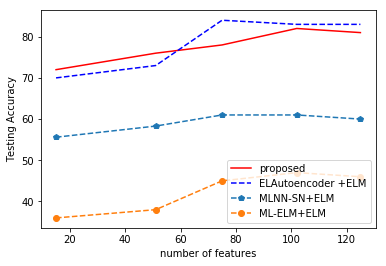

In [2]:
import matplotlib.path as mpath
import matplotlib.pyplot as plt
x = [15,51,75,102,125]
y1 = [72,76,78,82,81]
y2 = [70,73,84,83,83]
y3 = [55.6,58.3,61,61,60]
y4 = [36,38,45,47,46]

plt.plot(x,y1,'-r')
plt.plot(x,y2,'--b')
plt.plot(x,y3,'--p')
plt.plot(x,y4,'--o')
plt.ylabel('Testing Accuracy')
plt.xlabel('number of features')
plt.legend(['proposed', 'ELAutoencoder +ELM','MLNN-SN+ELM','ML-ELM+ELM'], loc='lower right')

In [24]:
def one_hot(y, classes):
    I = np.eye(classes)
    #print(I)
    ret = []
    l = 0
    for y_ in y:
        ret.append(I[y_])
            
    return np.array(ret)
    
y_train_onehot = one_hot(y_train, 15)
y_test_onehot = one_hot(y_test,15)

In [25]:
input_size = 51
output_size = 15 # mnist has 10 output classes 

In [26]:
from ml_elm import ML_ELM

mlelm1 = ML_ELM(input_size=input_size, output_size=output_size, name='mlelm1')

In [27]:
mlelm1.add_layer(n_neurons=101, l2norm=1e2);
#mlelm1.add_layer(n_neurons=51,  l2norm=1e2); 
#mlelm1.add_layer(n_neurons=1001,  l2norm=1e2); 
mlelm1.add_layer(n_neurons=101, activation=tf.tanh, l2norm=1e2); 

In [28]:
mlelm1.fit(x_train_encoded, y_train_onehot, batch_size=1000)

2019-05-29 11:47:25.425161 ML-ELM Start training...


ValueError: Cannot feed value of shape (4042, 125) for Tensor 'input_mlelm1/x:0', which has shape '(?, 51)'

In [ ]:
mlelm1.evaluate(x_test_encoded, y_test_onehot, batch_size=500)